In [1]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(dplyr, warn.conflicts = FALSE)
library(stringr, warn.conflicts = FALSE)

source("src/database/query/data.R")
source("src/database/startup.R")
source("src/load/tools.R")
source("src/load/ITA.R")
source("notebooks/integrazioni_regionali/procedure/common_steps.R")

conns <- load_dbs()

Caricamento del pacchetto richiesto: DBI

Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



In [8]:
regional_datasets <- tribble(
    ~reference_state, ~original_dataset, ~merged_dataset,
    "Piemonte", "ARPAPiemonte", "PIE",
    "Liguria", "ARPAL", "LIG",
    "Lombardia", "ARPALombardia", "LOM",
    "Veneto", "ARPAV", "VEN",
    "Trentino-Alto Adige", "TAA", "TAA2",
    "Friuli-Venezia Giulia", "ARPAFVG", "FVG",
    "Emilia-Romagna", "ARPAE", "ER",
    "Toscana", "SIRToscana", "TOS",
    "Umbria", "ARPAUmbria", "UMB",
    "Marche", "ARPAM", "MAR"
)
reg_boundaries <- load.italian_boundaries("state") |> filter(shapeName %in% c(regional_datasets$reference_state, "Friuli Venezia Giulia"))


In [22]:
data <- query_checkpoint_data(regional_datasets$merged_dataset, "merged", conns$data)
meta <- query_checkpoint_meta(regional_datasets$merged_dataset, "merged", conns$meta)

Saving 12 x 7 in image


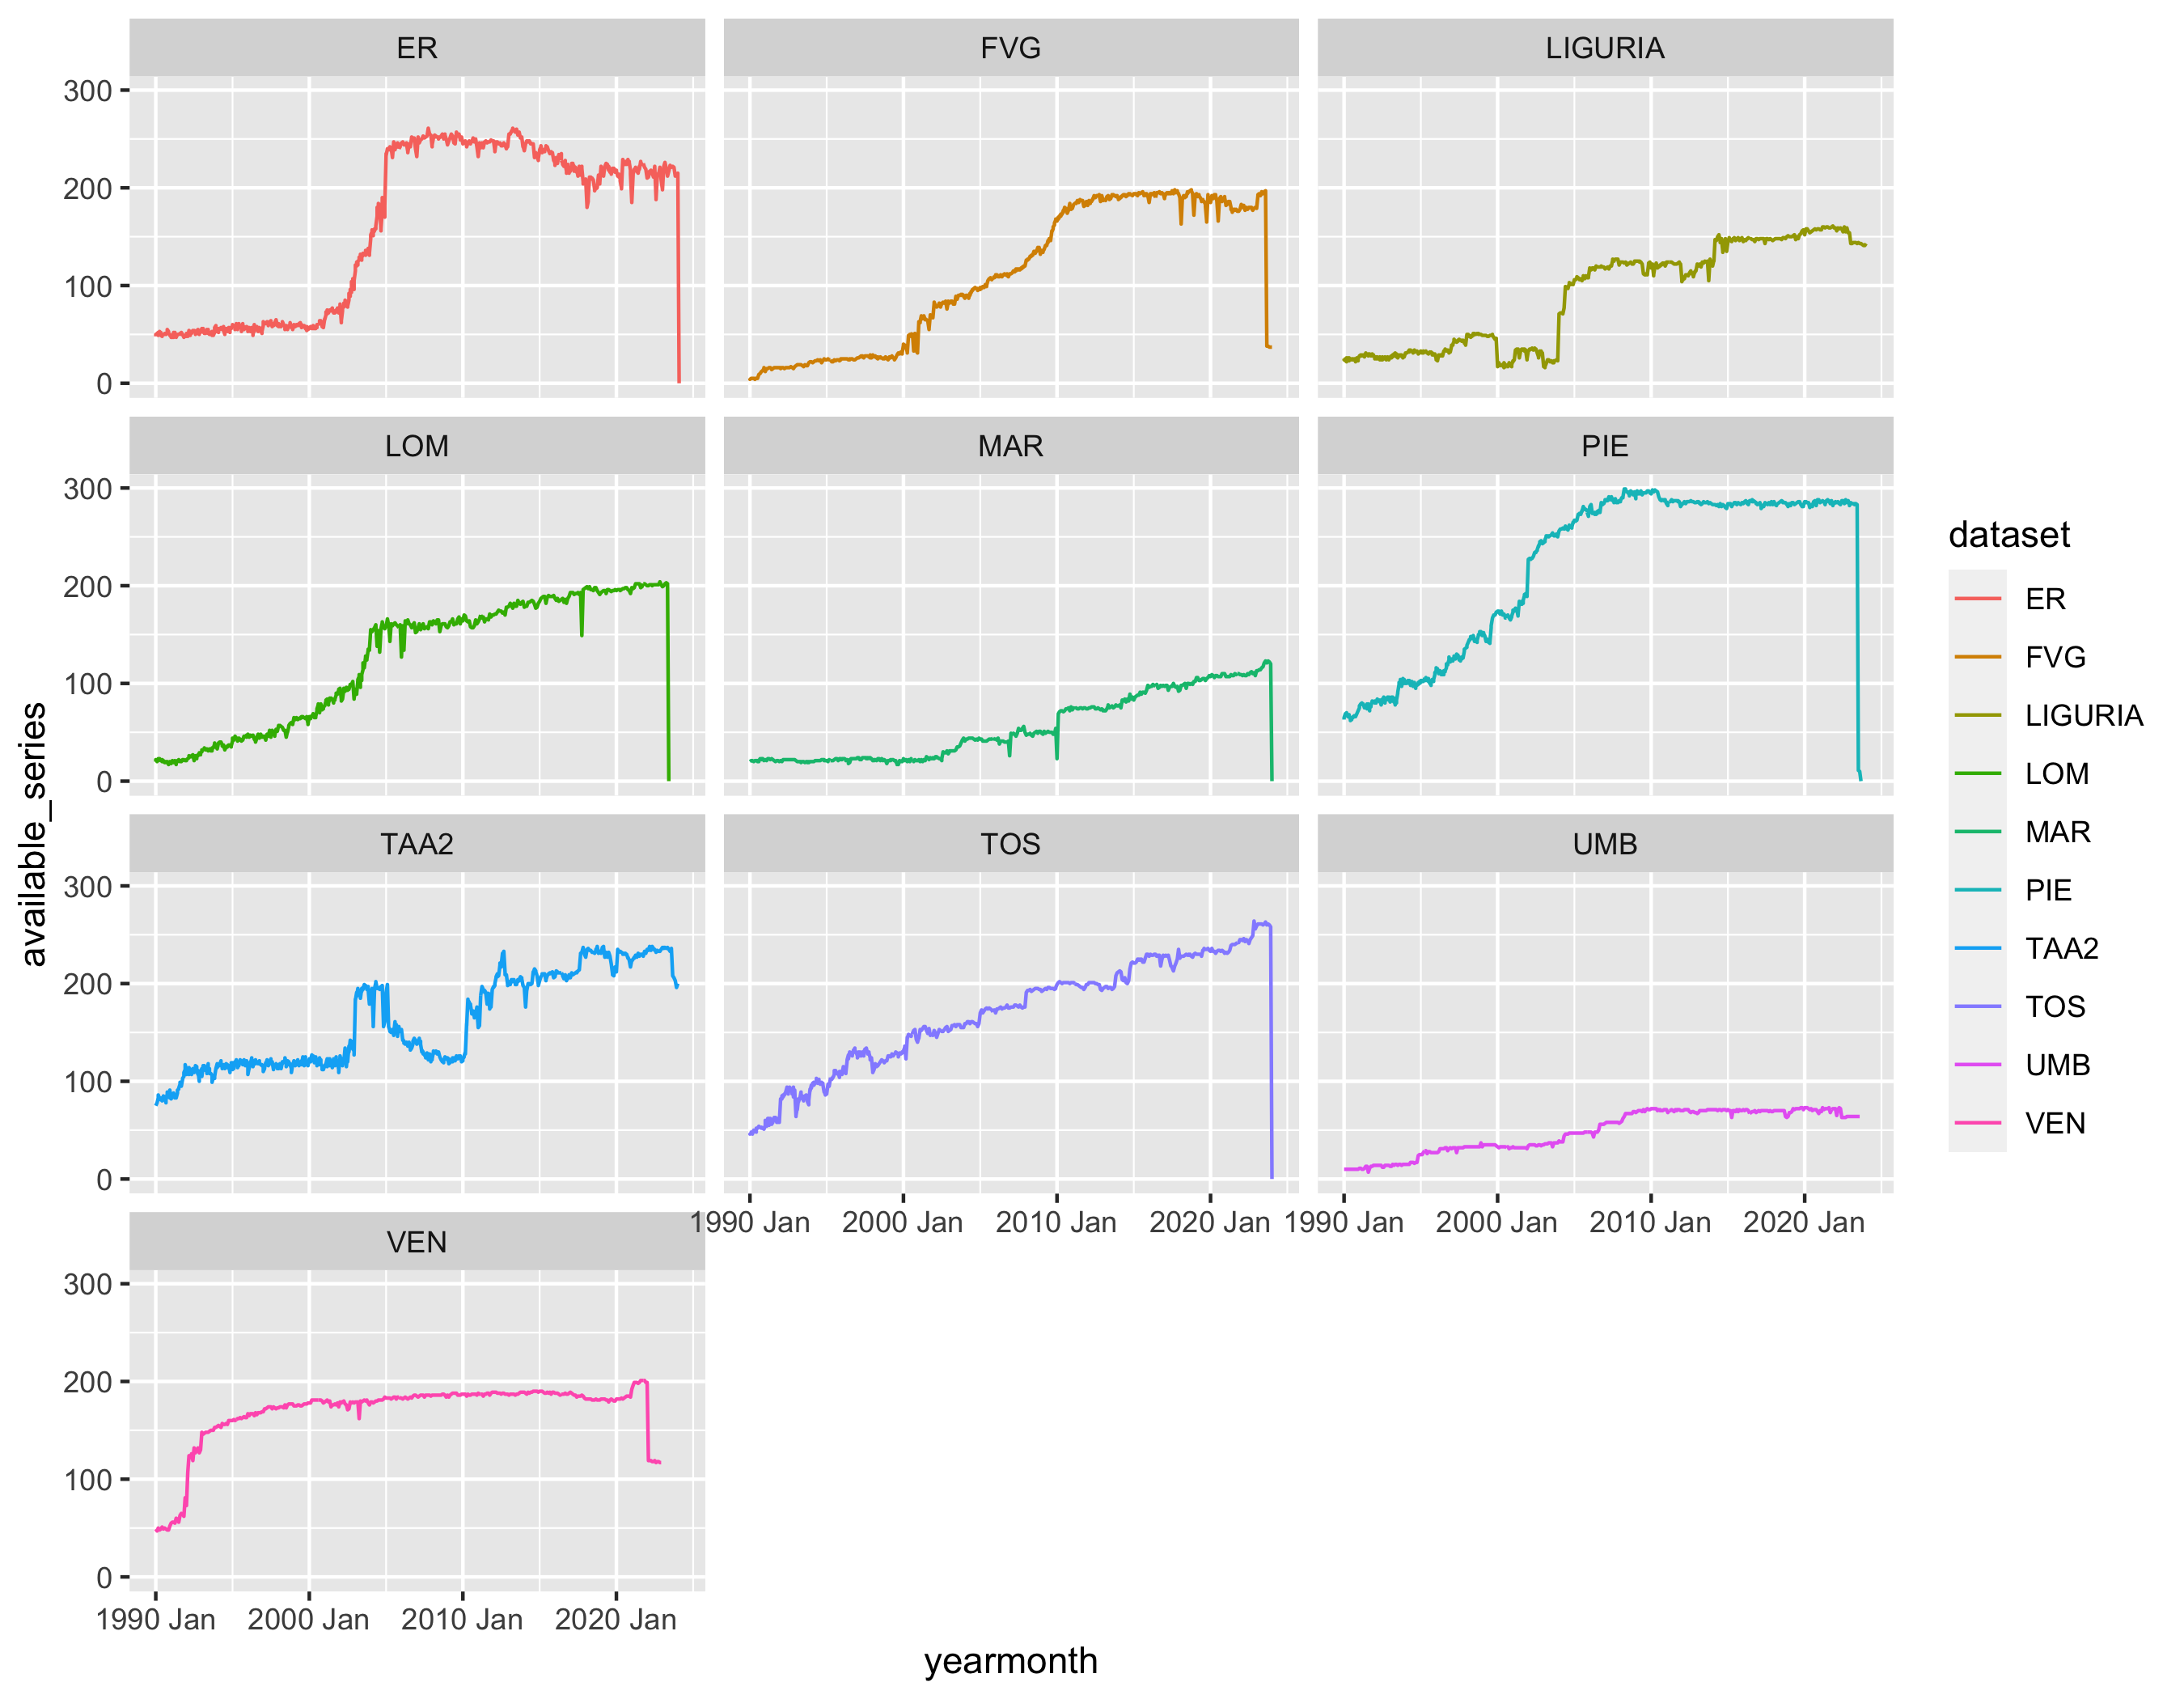

In [10]:
pd <- ymonthly_availabilities(data |> filter(year(date) >= 1990L), FALSE)
ggsave("plots/state_availabilities.pdf", pd$plot + facet_wrap(~ dataset, ncol = 3L), width = 12)
pd$plot + facet_wrap(~ dataset, ncol = 3L)

Saving 7 x 7 in image


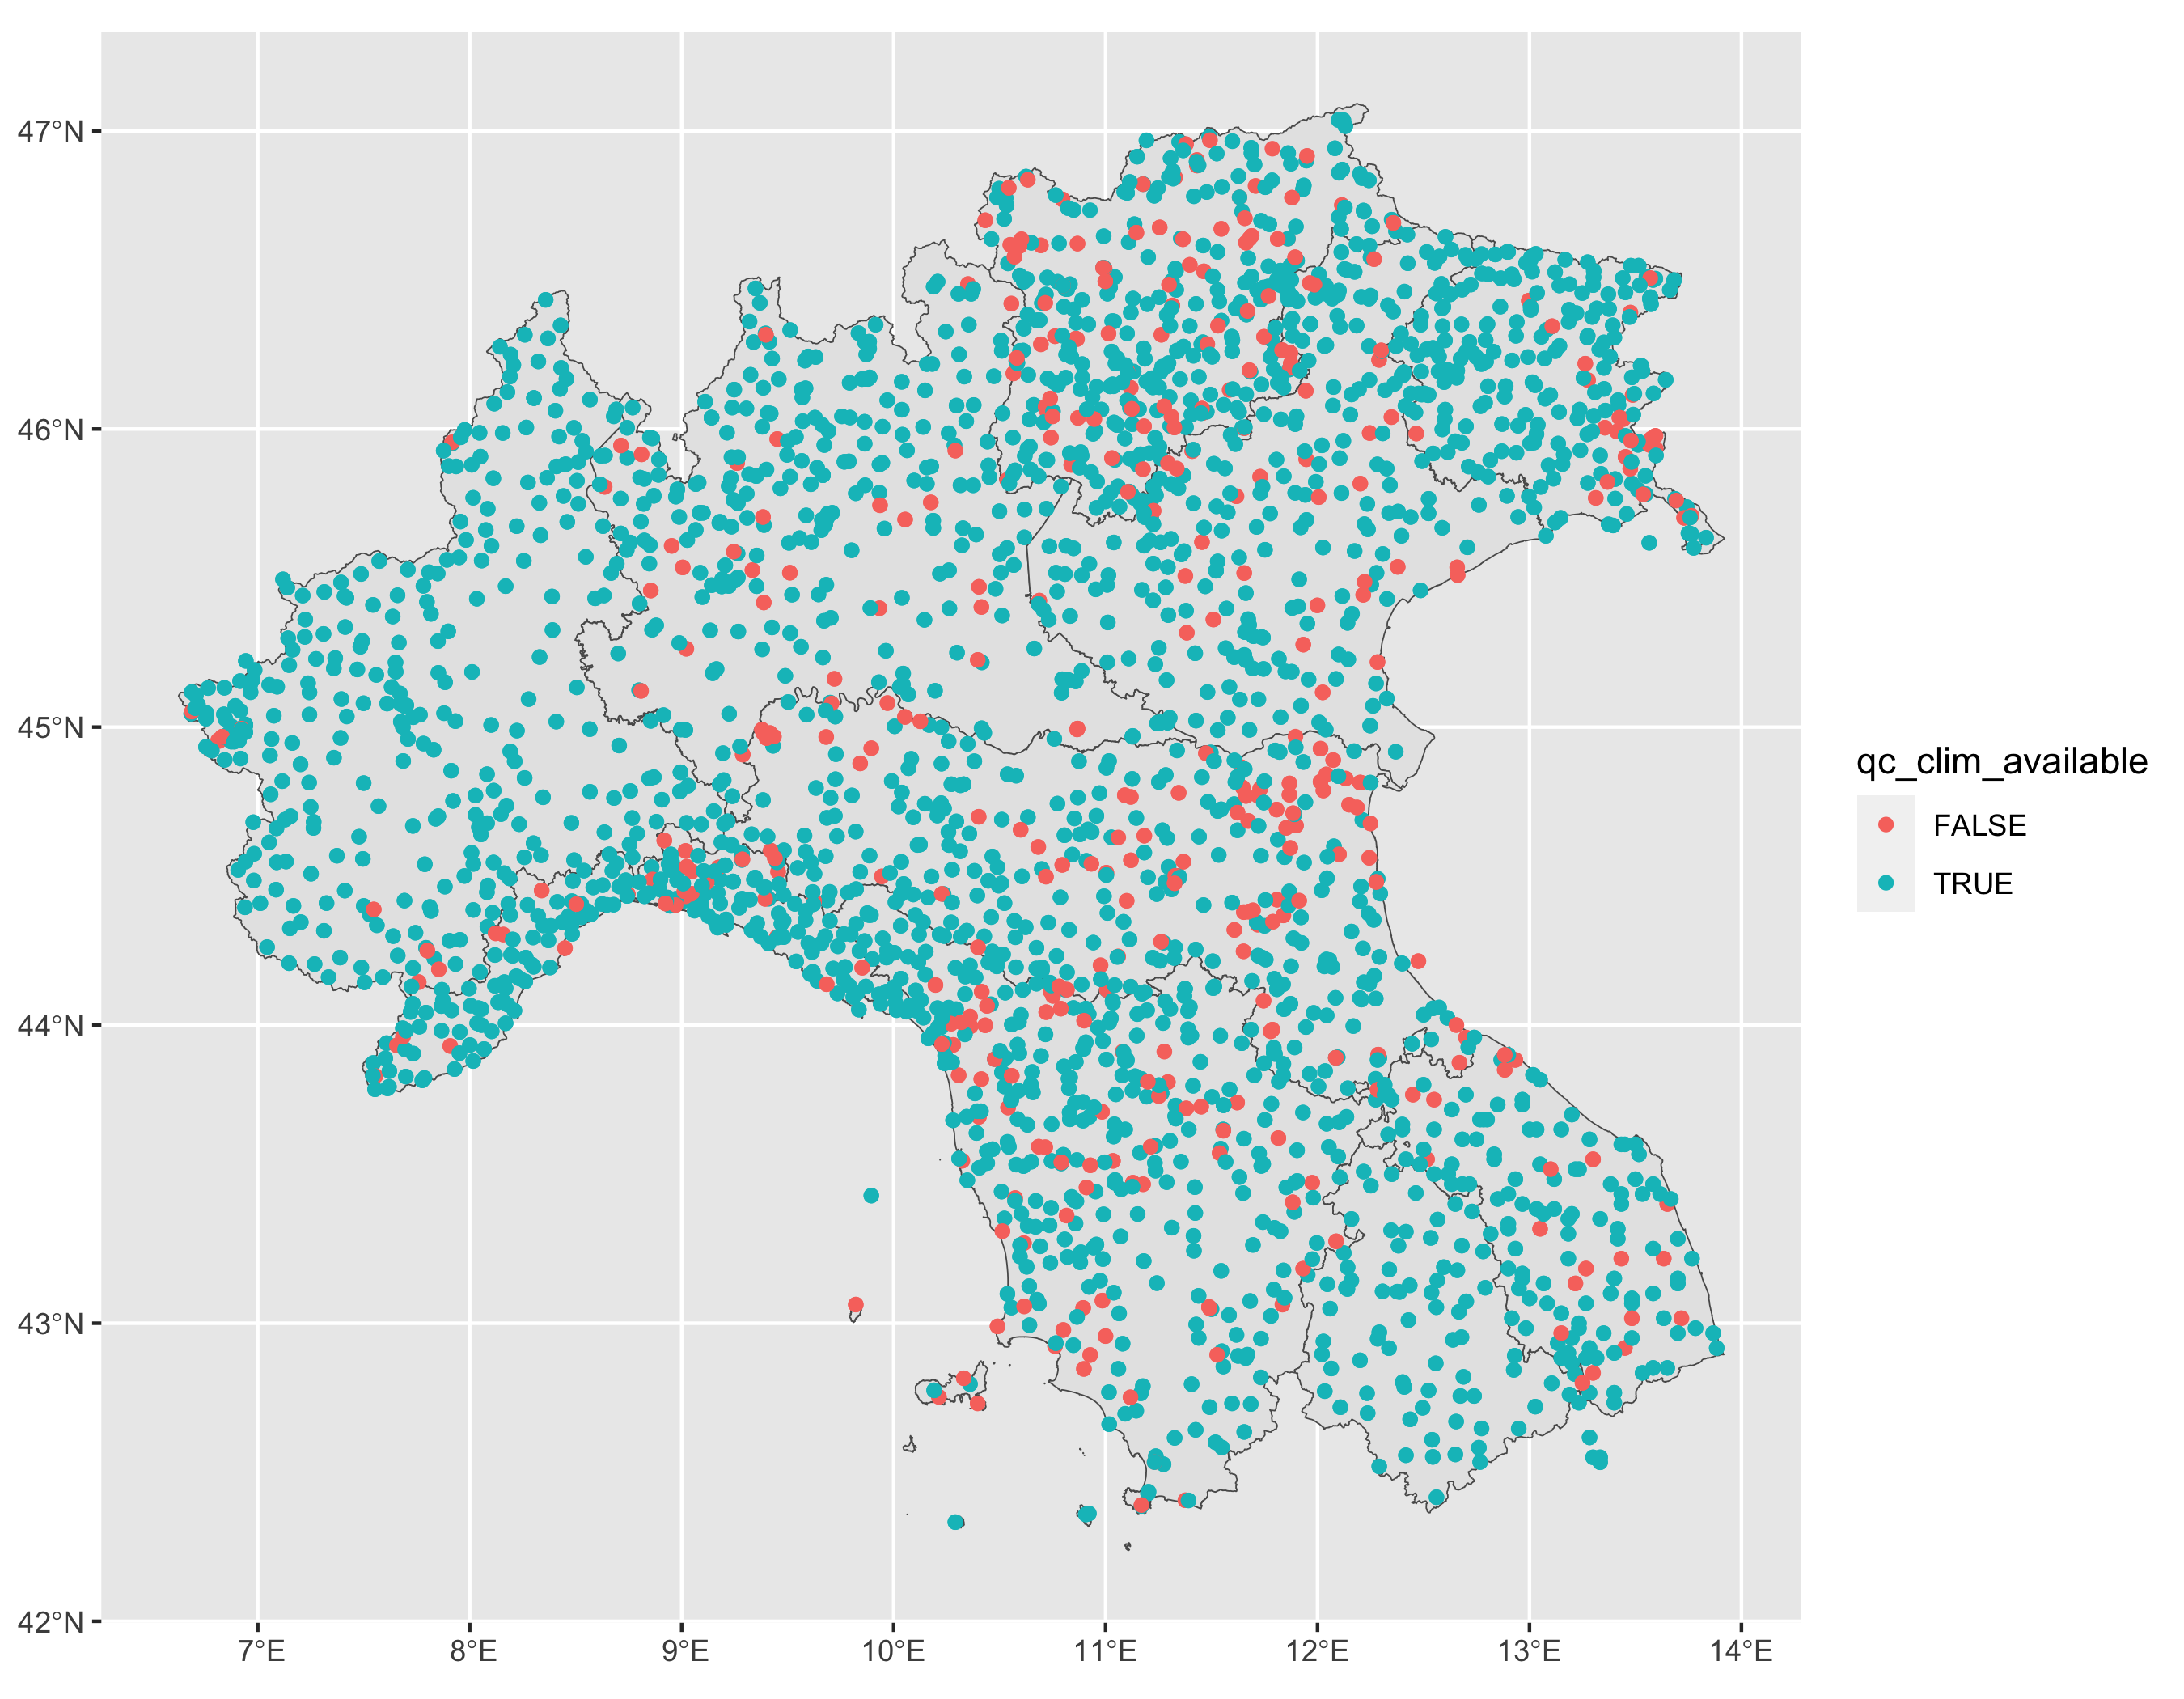

In [11]:
ps <- spatial_availabilities(pd$data, meta, reg_boundaries, n_years_threshold = 5L)
ggsave("plots/spatial_availability.pdf", ps$plot)
ps$plot

Warning message:
"Removed 2 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 2 rows containing non-finite values (`stat_bin()`)."


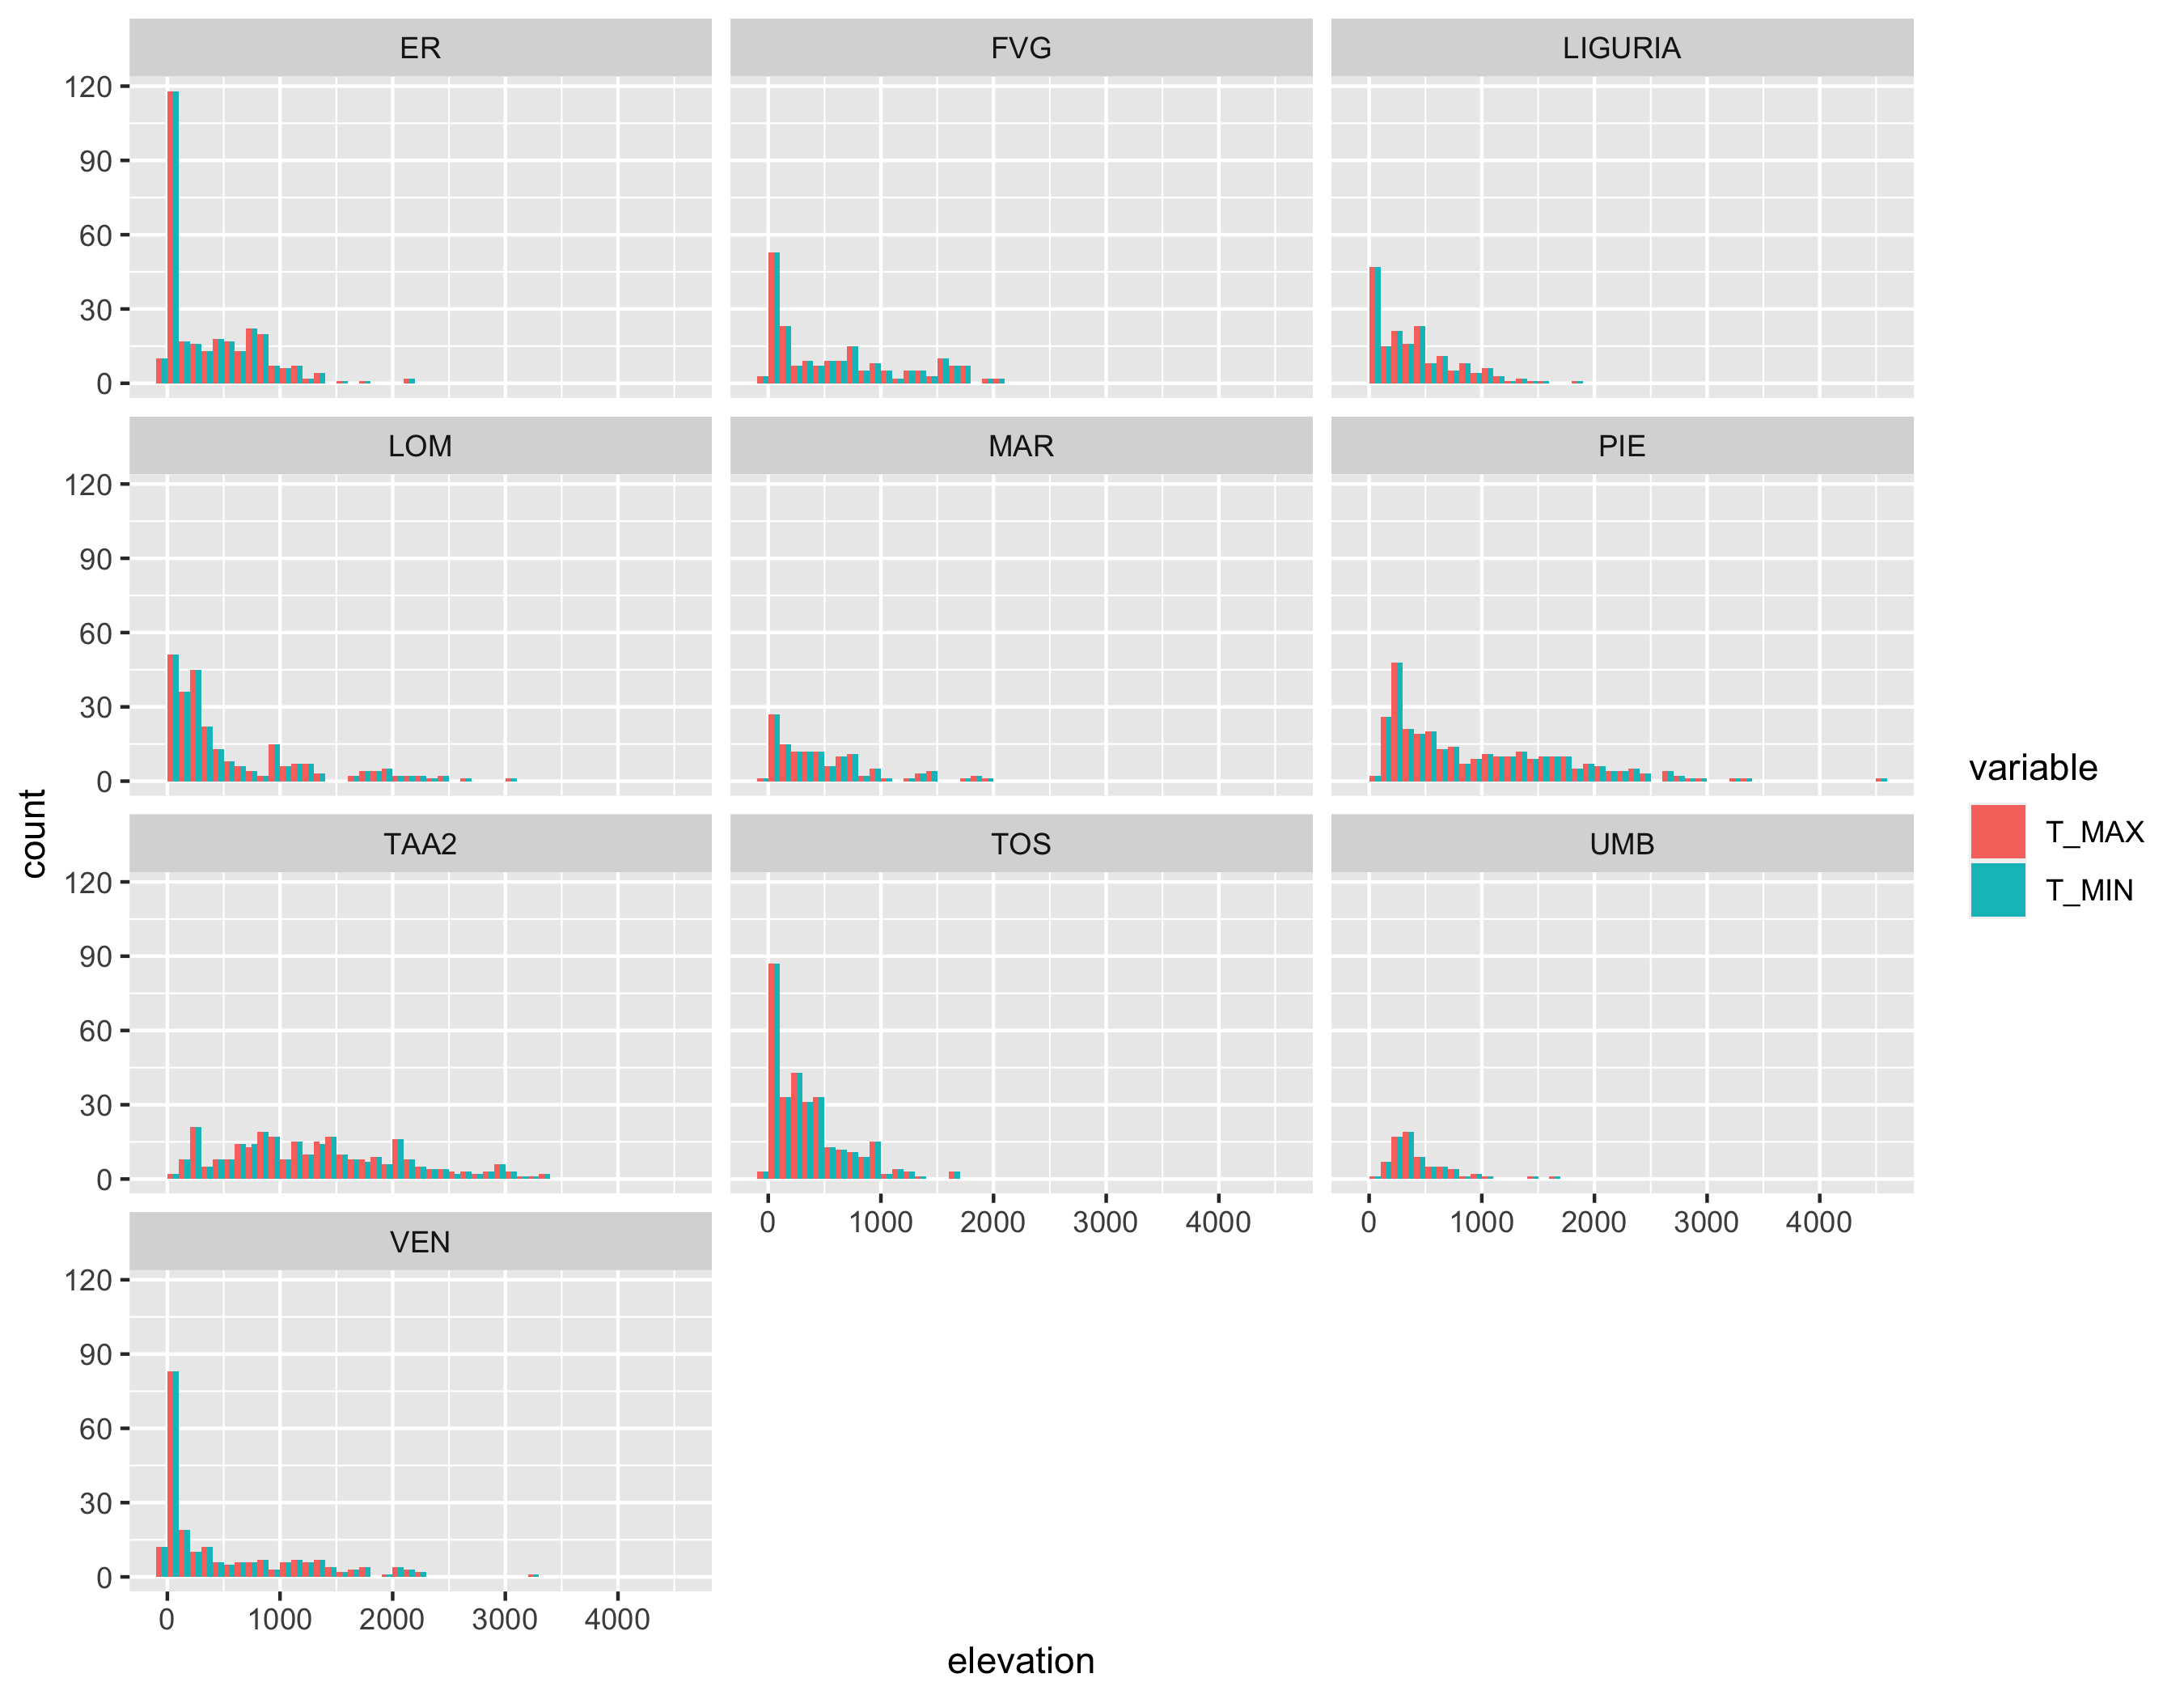

In [12]:
p <- plot_available_by_elevation(ps$data, meta |> collect()) + facet_wrap(~ dataset, ncol = 3L)
ggsave("plots/availability_by_elevation.pdf", p, width = 12, height = 8, units = "in", dpi = 300)
p

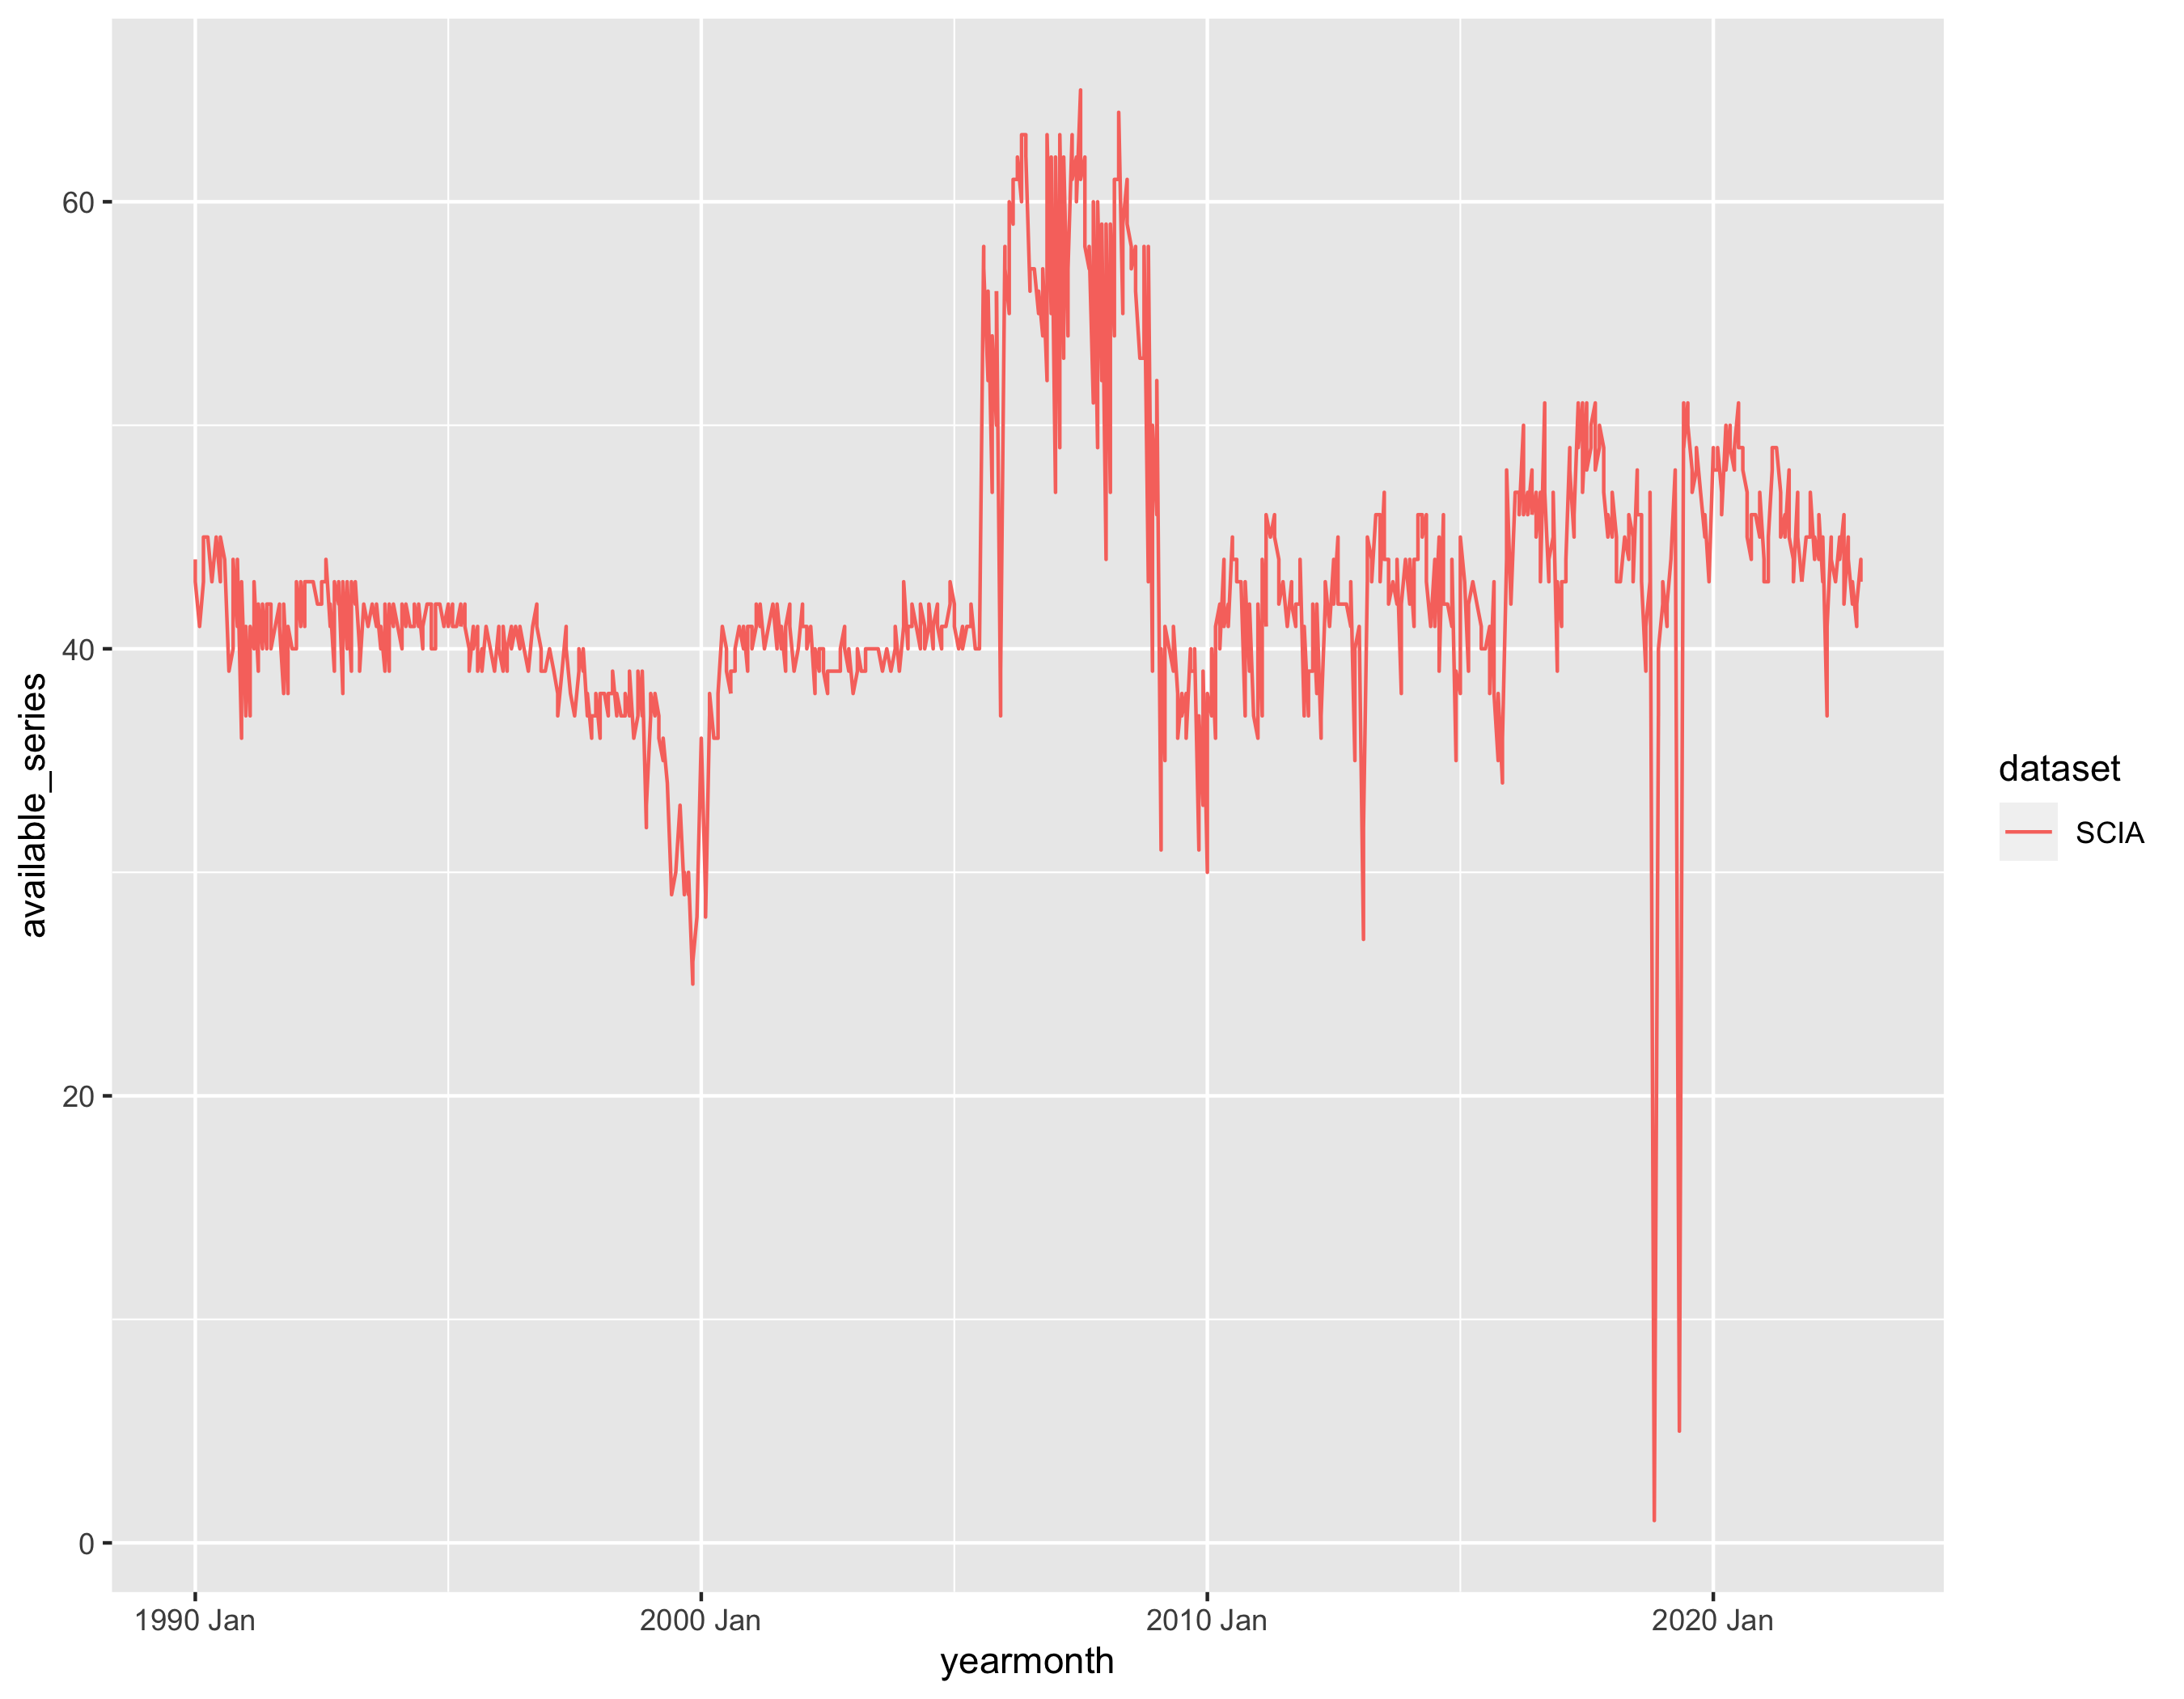

In [23]:
scia_synop_mareo_meta <- query_checkpoint_meta("SCIA", "qc1", conns$data) |> filter(network %in% c("Sinottica", "Mareografica"), lat > 42, !(state %in% c("Abruzzo", "Lazio")))
scia_synop_mareo_data <- query_checkpoint_data("SCIA", "qc1", conns$data) |> semi_join(scia_synop_mareo_meta, by = "sensor_key")
pd <- ymonthly_availabilities(scia_synop_mareo_data |> filter(year(date) >= 1990L, valid), FALSE)
pd$plot

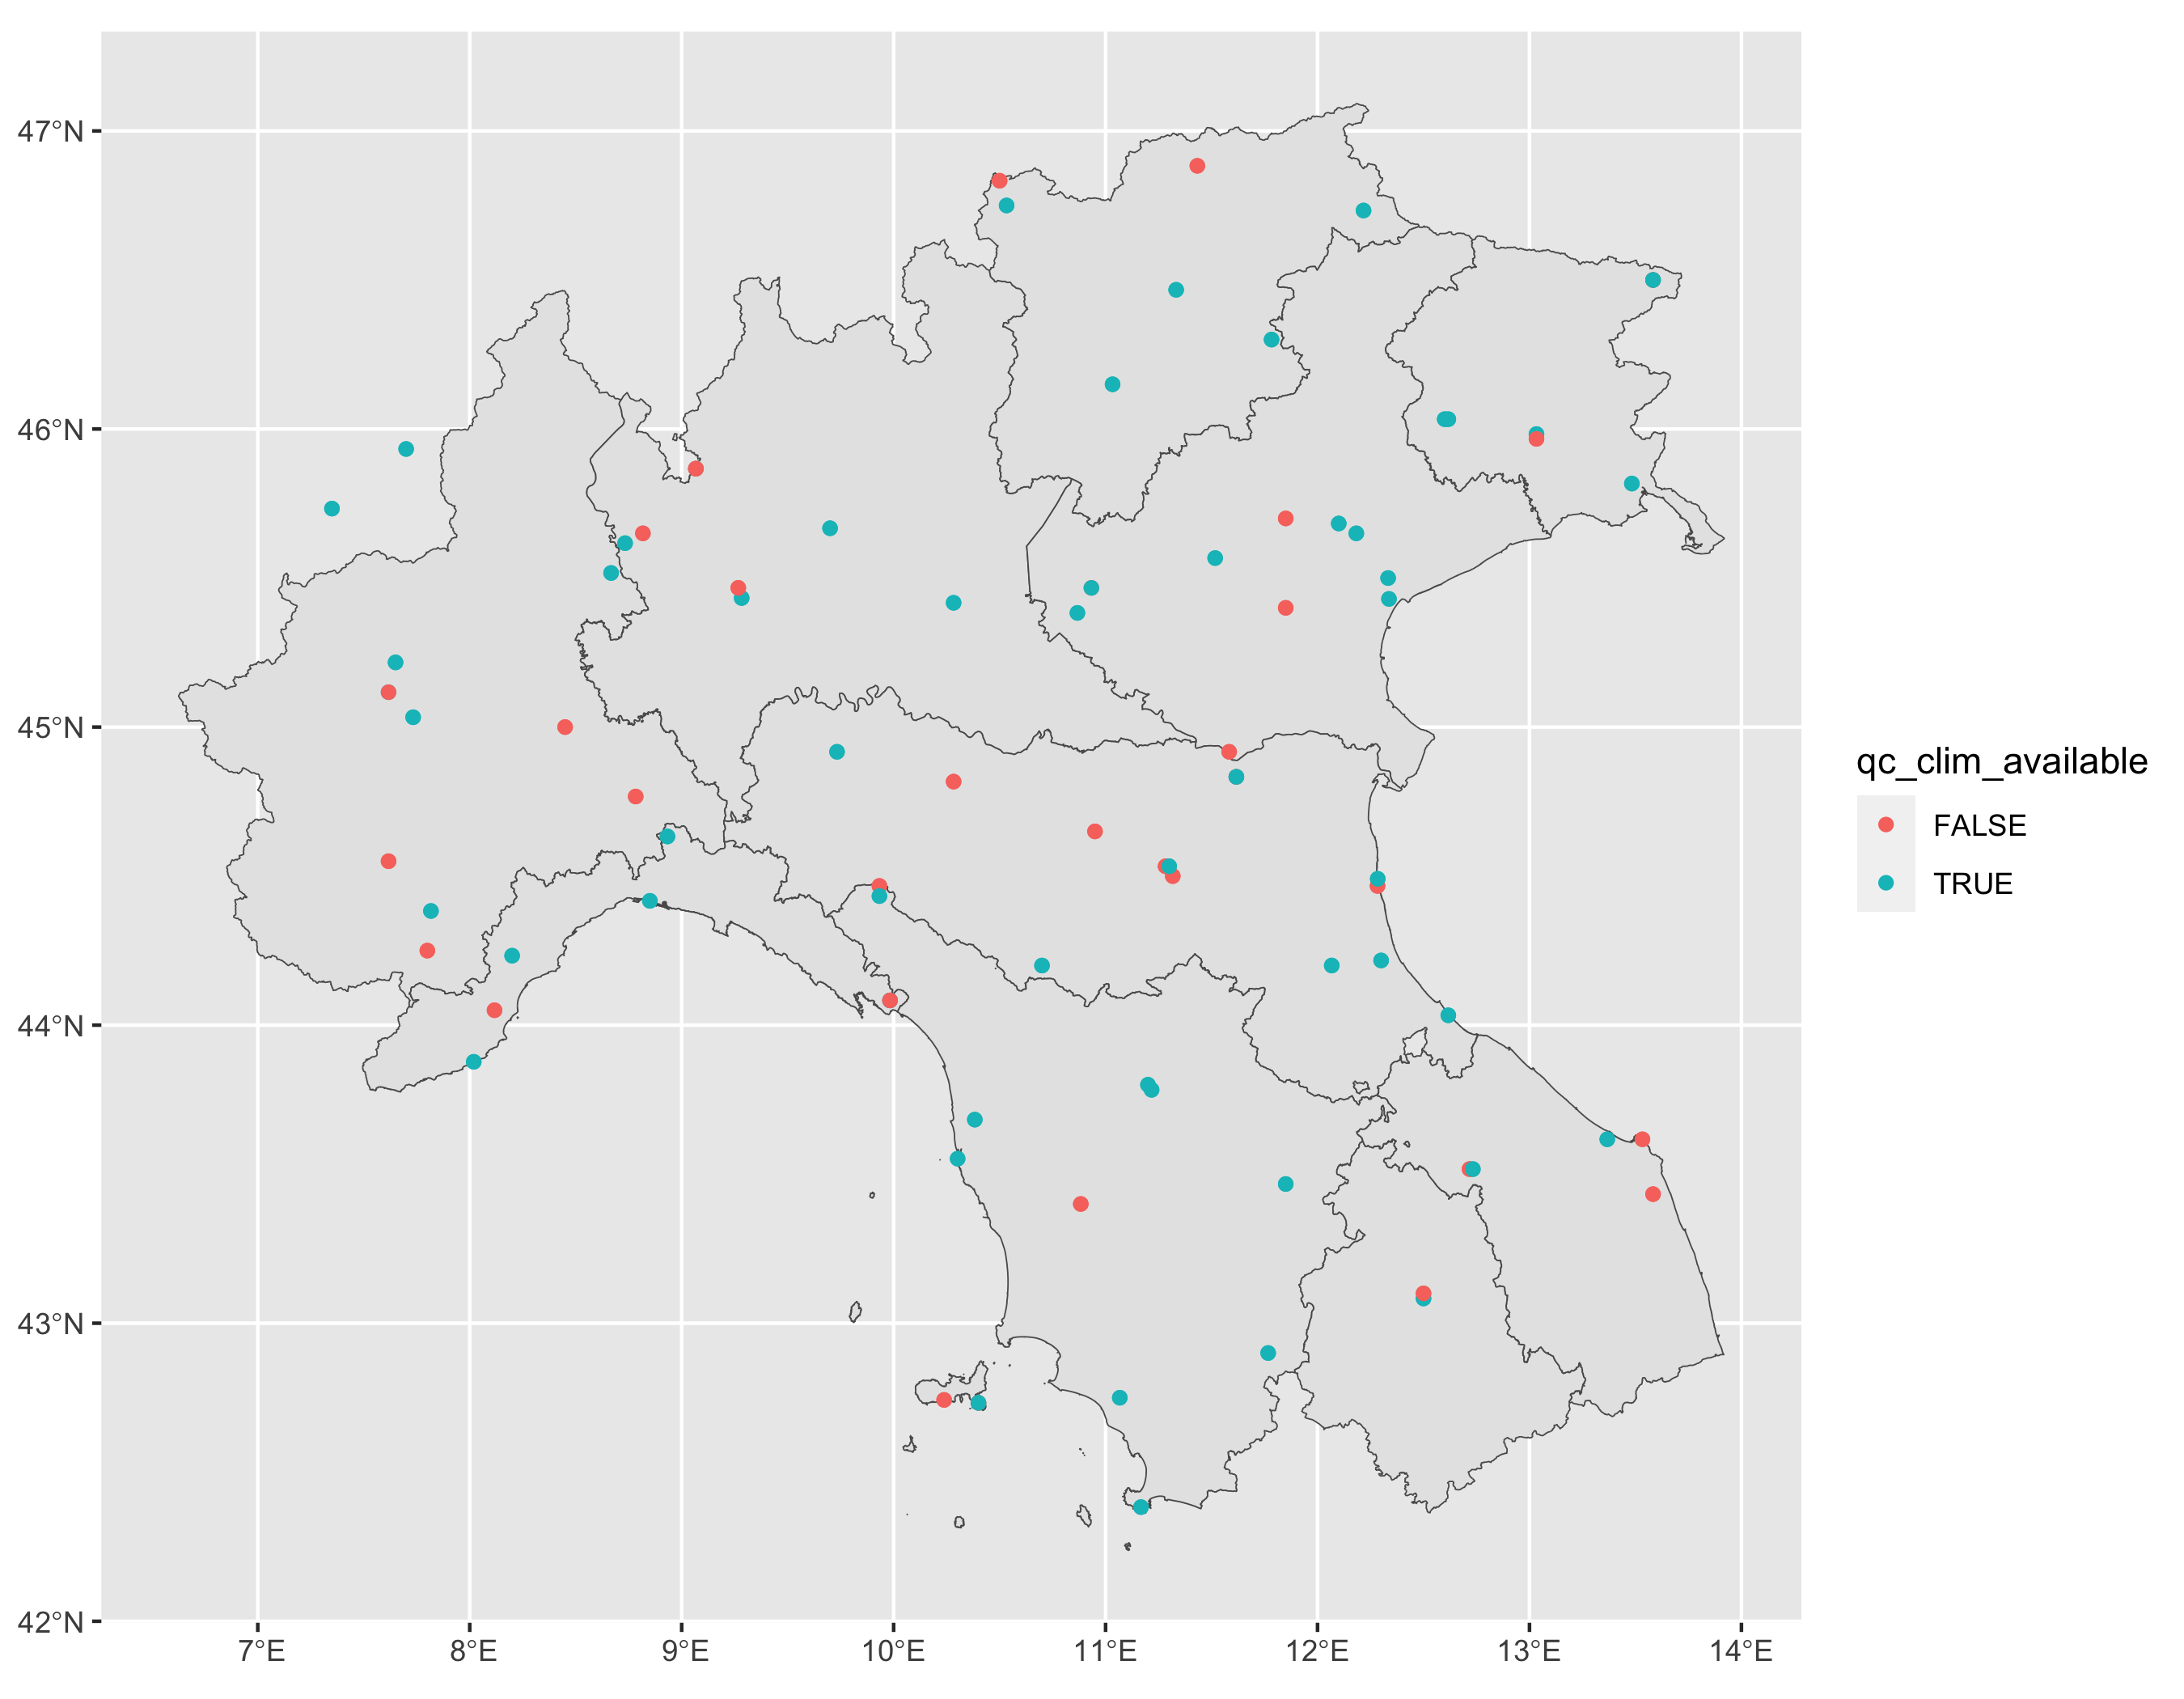

In [25]:
ps <- spatial_availabilities(pd$data, scia_synop_mareo_meta, reg_boundaries, n_years_threshold = 5L)
ps$plot